## Load in imports and data

Last working weekly: w2024_29

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

# interpolation mask threshold
import lsst.geom as geom

Confirm which version of packages are setup on the notebook environment.

In [2]:
# import lsst.pipe.tasks, lsst.drp.tasks, lsst.cell_coadds
# print(lsst.pipe.tasks.__file__)
# print(lsst.drp.tasks.__file__)
# print(lsst.cell_coadds.__file__)

In [3]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508' # updated patch 61 collection
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

Patches to choose from: [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [4]:
patch = 50

In [5]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [6]:
# stitch_coadd = coadd.stitch() # fails with empty cells
explode_coadd = coadd.explode()

In [7]:
cell_list_filled = list(coadd.cells.keys())

In [8]:
cell_list = []
cells_filled = [False] * 484

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

In [9]:
# example on how to use equivalent of np.where on lists
# cell_list_test = [cell_list[index] for index, val in enumerate(cells_filled) if val == True]

In [10]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [11]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.zeros([22,22])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [12]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## 1D Cell Inputs

### Plotting cell input 1D histogram

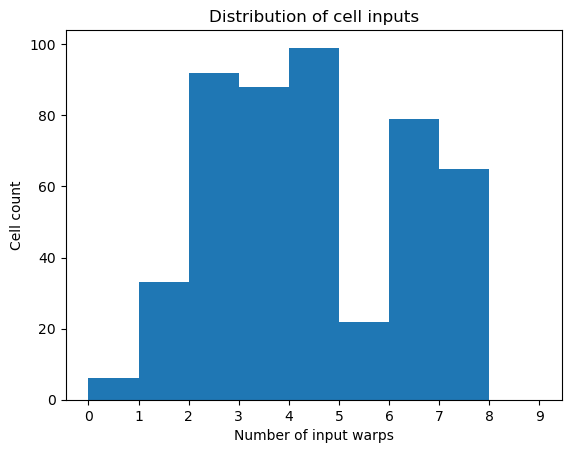

In [13]:
flat_inputs_list = inputs_list.flatten()

bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(flat_inputs_list, bins)
plt.show()

## Plot mask information

There is probably a more efficient way to do this but this is for a first try

Text(0, 0.5, 'Cell count')

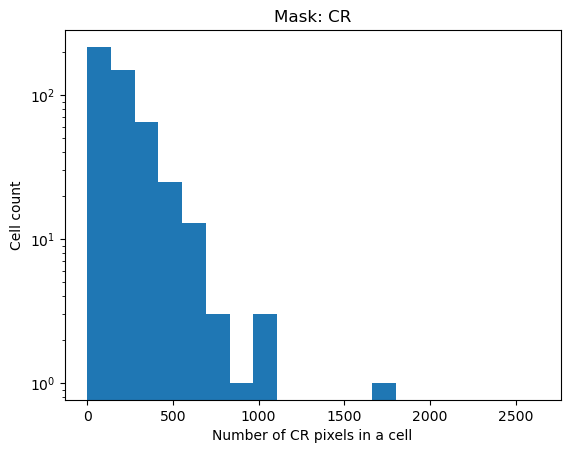

In [14]:
num_mask_pix = []
plot_mask = 'CR'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
some_cell = coadd.cells[cell_list_filled[0]]
mask_bit = some_cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list_filled:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    # optionally print cells that contain the defined masked pixels
    # if num_bad_pixels > 0:
    #     print(cell_index)
    num_mask_pix.append(num_bad_pixels)
    
num_mask_pix = np.array(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, (np.max(num_mask_pix)+1)/20)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

## Generate 2D histogram of number of cell inputs across a patch

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [15]:
# stitch_coadd.asExposure().getDimensions()

Get the grid structure of the stitched coadd:

In [16]:
# print(stitch_coadd.grid)

Plot the 2D grid of cell inputs:

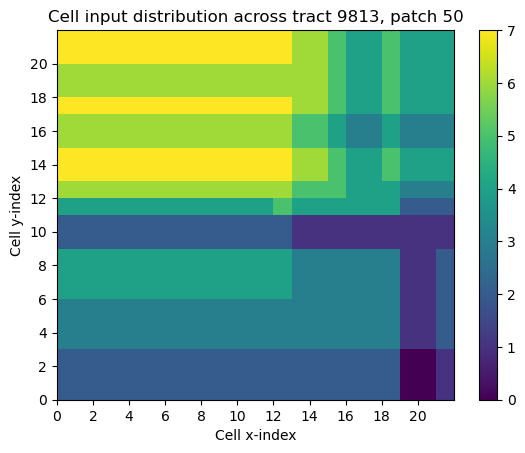

In [17]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.title(f"Cell input distribution across tract 9813, patch {patch}")
plt.xlabel("Cell x-index")
plt.ylabel("Cell y-index")
plt.colorbar()

Brief check that index of cells are lining up as expected, since numpy indexes 2D arrays differently.

In [18]:
# for patch 61
# print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
# print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
# print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

### Display above histogram over the stitched coadd

Maybe not as useful as I had hoped, but still an interesting exercise in manipulating array images.

In [19]:
# flipped_stitch = np.flip(stitch_coadd.image.getArray(), axis=0)

Many different ways to retrieve the bounding box coordinates:

In [20]:
# # coadd pixel coordinates for minimum corner and maximum corner
# print(stitch_coadd.bbox)
# # split up the four values
# print(stitch_coadd.bbox.beginX)
# print(stitch_coadd.bbox.beginY)
# print(stitch_coadd.bbox.maxX)
# print(stitch_coadd.bbox.maxY)
# # get each corner
# print(stitch_coadd.bbox.getBegin())
# print(stitch_coadd.bbox.getMax())

Remove the image padding (50 pixels added to each side, actual image should be 3300x3300 pixels:

In [21]:
# bbox = afwGeom.Box2I()
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
# cutout = stitch_coadd.asExposure()[bbox]
# print(cutout.getDimensions())

In [22]:
# from matplotlib.colors import LogNorm
# plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), alpha=0.5)
# # extent = np.min(x), np.max(x), np.min(y), np.max(y)
# extent = 0, 3300, 0, 3300
# im1 = plt.imshow(np.flip(inputs_list, axis=0), alpha=0.5, extent=extent)
# color1 = plt.colorbar(im1)
# im2 = plt.imshow(np.flip(cutout.image.getArray(), axis=0), cmap='gray', norm=LogNorm(), extent=extent)
# color2 = plt.colorbar(im2)
# plt.show()

### Check DC2 run for interpolation errors in warps

In [35]:
dc2_repo = '/sdf/data/rubin/repo/dc2/'
collection_dc2 = 'u/mgorsuch/assemble_cell_coadd_patch_61/20240509T184123Z'
dc2_butler = Butler(dc2_repo)
dc2_registry = dc2_butler.registry

In [36]:
for ref in dc2_butler.registry.queryDatasets('deepCoadd_directWarp', collections=collection_dc2):
    print(ref.dataId)

{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 162699, band: 'r', day_obs: 20220806, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193147, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193189, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193232, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193233, band: 'r', day_obs: 20220916, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193888, band: 'r', day_obs: 20220917, physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visi

In [37]:
warp_dc2 = dc2_butler.get('deepCoadd_directWarp',
                   collections = collection_dc2,
                   instrument='LSSTCam-imSim',
                   skymap = 'DC2_cells_v1',
                   tract = 3828,
                   patch = 42,
                   visit = 212071)

In [38]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp_dc2.maskedImage)